In [1]:
import pandas as pd
import numpy as np
import describe as tatl
import wrangle as get
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# feature selection imports
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

# import scaling methods
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, QuantileTransformer
# import modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, mutual_info_score

from mitosheet import *
import plotly.express as px
# import to remove warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
df, train, validate, test = get.wrangle_df()

Dataframe Input received: Splitting Data .5/.3/.2.
Train: (150, 47), Validate (90, 47), and Test (60, 47) are ready.    
 Proceed with EDA.


To trim my dataframe some and eliminate features that at first glance seem to not bear any significance on a country's suicide rate, 
I will discard any features that do not have at least a +/- .33 correlation with my target, 'both_sexes'. This is before any consideration of scaling or adjust based on the per 100,000 factor set through WHO. 

In [4]:
def suicide_heatmap(train):
    plt.figure(figsize=(12,12))
    heatmap = sns.heatmap(train.corr()[['both_sexes']].sort_values(by='both_sexes', ascending=False), vmin=-.5, vmax=.5, annot=True,cmap='flare')
    heatmap.set_title('Features Correlated with Suicide')
    return heatmap

In [8]:
#suicide_heatmap(train)

In [ ]:
train.columns

In [5]:
#import itertools
#
#quant_dogs = ['both_sexes','rgdpe', 'rgdpo', 'pop','emp', 'avh', 'hc', 'ccon', 'cda', 'cgdpe', 'cgdpo']
#
#def plot_variable_pairs(train, cols, hue=None):
#    '''
#    This function takes in a df, a list of cols to plot, and default hue=None 
#    and displays a pairplot with a red regression line.
#    '''
#    plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.7}}
#    sns.pairplot(train[cols], hue=hue, kind="reg",plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})
#    plt.show()
#    
#plot_variable_pairs(train, quant_dogs)

In [10]:
# I will go through and add this to my prepare function, or include it as pre-processing. 
eliminate = ['csh_m', 'xr', 'rkna', 'avh', 'hc', 'pop', 'csh_x', 'emp', 'pl_i', 'pl_n', 'pl_m', 'male', 'female', 'countrycode', 'currency_unit']

In [11]:
train2 = train.drop(columns=eliminate, axis=1)

In [12]:
train2.columns

Index(['country', 'rgdpe', 'rgdpo', 'ccon', 'cda', 'cgdpe', 'cgdpo', 'cn',
       'ck', 'ctfp', 'cwtfp', 'rgdpna', 'rconna', 'rdana', 'rnna', 'rtfpna',
       'rwtfpna', 'labsh', 'irr', 'delta', 'pl_con', 'pl_da', 'pl_gdpo',
       'csh_c', 'csh_i', 'csh_g', 'csh_r', 'pl_c', 'pl_g', 'pl_x', 'pl_k',
       'both_sexes'],
      dtype='object')

In [2]:
# Just updated wrangle so these columns were dropped, let's check the results
df, train, validate, test = get.wrangle_df()
# 17 less columns. More manageable. 

Dataframe Input received: Splitting Data .5/.3/.2.
Train: (150, 32), Validate (90, 32), and Test (60, 32) are ready.    
 Proceed with EDA.


<AxesSubplot:title={'center':'Features Correlated with Suicide'}>

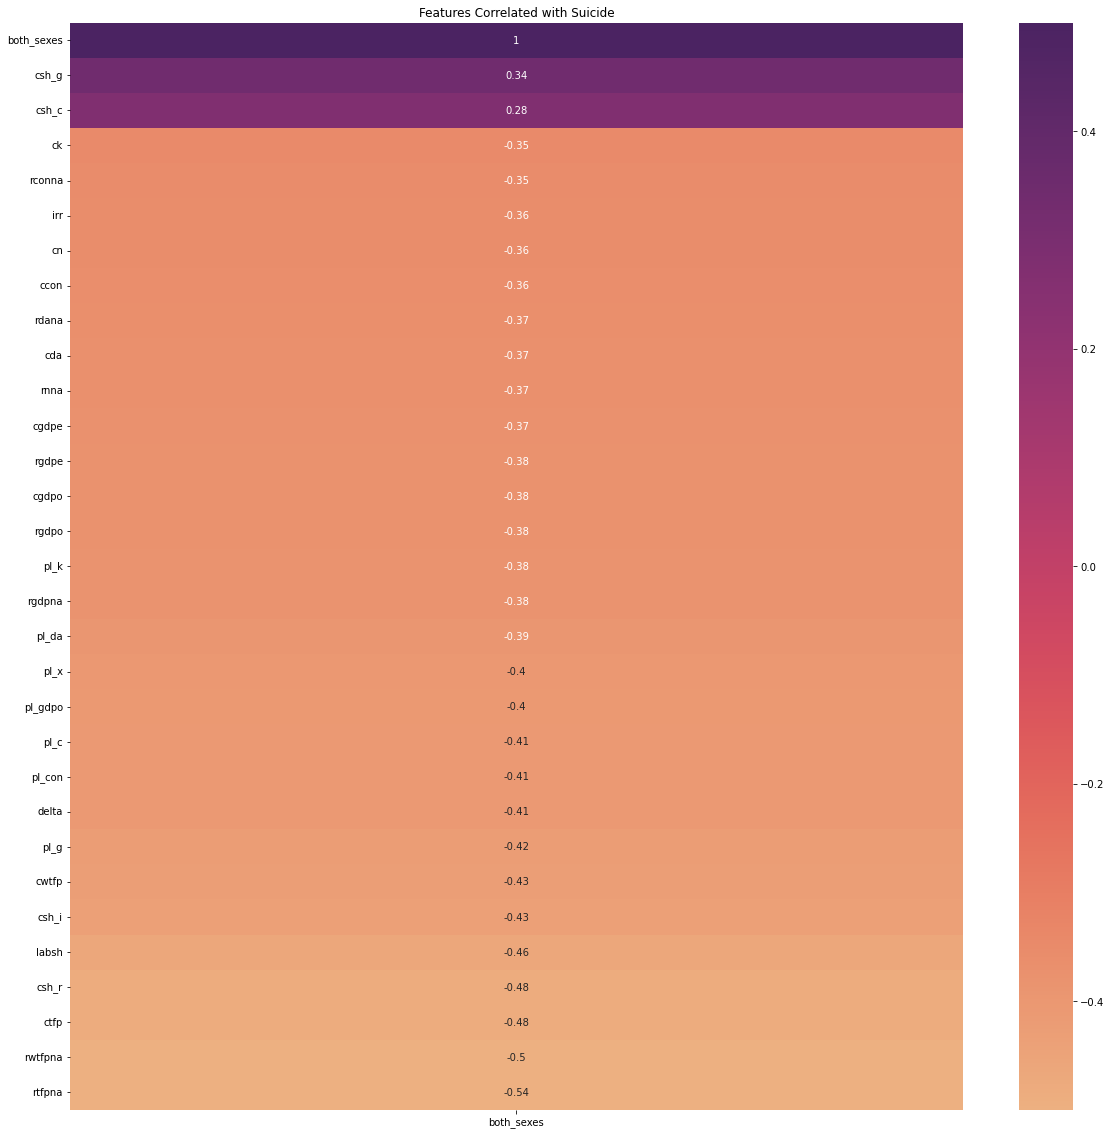

In [6]:
suicide_heatmap(train)

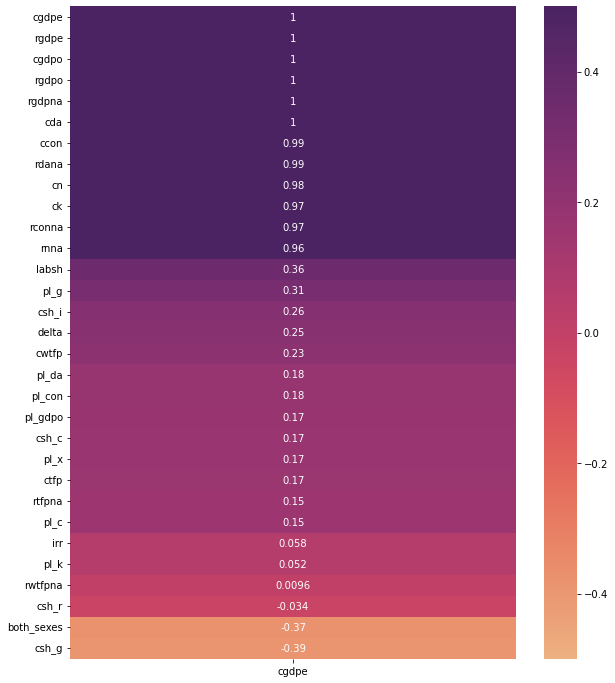

In [12]:
# I am interested in CGDPe, so I will check to see if there are any others too closely correlated with it. 
plt.figure(figsize=(10,12))
heatmap = sns.heatmap(train.corr()[['cgdpe']].sort_values(by='cgdpe', ascending=False), vmin=-.5, vmax=.5, annot=True,cmap='flare')

In [14]:
# as anticipated, many are nearly perfectly correlated with the CGDPe; as such, their redundancy is unwelcome. 
demolition = ['rgdpe', 'rgdpo', 'ccon', 'cda',  'cgdpo', 'cn', 'rgdpna', 'rdana', 'ck', 'rconna', 'mna']


In [2]:
df, train, validate, test = get.wrangle_df()

Dataframe Input received: Splitting Data .5/.3/.2.
Train: (150, 21), Validate (90, 21), and Test (60, 21) are ready.    
 Proceed with EDA.


In [3]:
train

,country,cgdpe,ctfp,cwtfp,rtfpna,rwtfpna,labsh,irr,delta,pl_con,...,pl_gdpo,csh_c,csh_i,csh_g,csh_r,pl_c,pl_g,pl_x,pl_k,both_sexes
year,,,,,,,,,,,,,,,,,,,,,
2000-01-01 00:00:00,Canada,1.263746e+06,0.956984,0.860486,0.996891,0.895117,0.653895,0.070429,0.034713,0.617853,...,0.584462,0.548439,0.238143,0.148169,7.772501e-03,0.581162,0.753662,0.513459,0.808440,10.7
2000-01-01 01:00:00,China,5.543108e+06,0.334550,0.316590,0.775058,0.520450,0.591962,0.108774,0.053817,0.195236,...,0.219550,0.467341,0.269803,0.246626,-2.958910e-03,0.220126,0.148072,0.447197,0.560159,14.9
2000-01-01 02:00:00,Czech Republic,2.206892e+05,0.498917,0.489100,0.744279,0.808748,0.514873,0.034440,0.038135,0.258797,...,0.280269,0.507060,0.261928,0.250133,0.000000e+00,0.278533,0.218788,0.469314,0.357402,13.4
2000-01-01 03:00:00,Germany,2.979410e+06,0.982710,0.929088,0.913306,0.973327,0.654206,0.047403,0.034413,0.653433,...,0.642094,0.596008,0.242488,0.144355,0.000000e+00,0.606525,0.847104,0.515353,0.854531,11.2
2000-01-01 04:00:00,Finland,1.823752e+05,0.931527,0.802571,0.978594,0.946530,0.566256,0.084294,0.038792,0.731130,...,0.675792,0.465355,0.271402,0.158905,-5.718203e-03,0.694162,0.839391,0.504715,1.085940,21.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-01-01 10:00:00,Lithuania,6.456963e+04,0.670751,0.713916,0.861996,0.878160,0.532920,0.079736,0.037518,0.567094,...,0.623182,0.690046,0.116066,0.289112,-3.717885e-08,0.612641,0.458383,0.633214,0.942484,33.1
2009-01-01 11:00:00,Poland,8.254608e+05,0.820949,0.826307,0.911430,0.946534,0.560190,0.126305,0.047483,0.509902,...,0.546367,0.625612,0.173974,0.236134,1.973058e-02,0.538588,0.433900,0.652941,1.205102,16.1
2009-01-01 12:00:00,Singapore,3.435229e+05,0.755546,0.651930,0.999746,1.049580,0.457446,0.135580,0.048958,0.609848,...,0.656793,0.400030,0.359812,0.128043,1.123544e-01,0.642015,0.509354,0.652682,0.863112,9.0


<AxesSubplot:title={'center':'Features Correlated with Suicide'}>

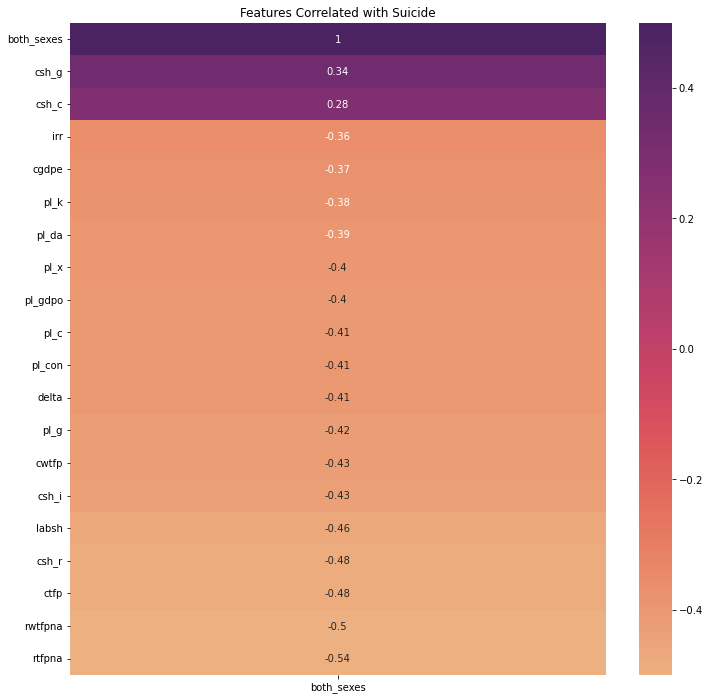

In [5]:
suicide_heatmap(train)

A Quick Rundown of what each of these represent
 
rtfpna: Total Factor Productivity (TFP) at constant national prices (2017=1) 
rwtfpna: Welfare-relevant TFP at constant national prices (2017=1) \n
ctfp: TFP level at current Purchasing Power Parities (PPP) (USA=1) \n
csh_r: 
labsh:
csh_i:
cwtfp:
pl_g:
delta:
pl_con:
pl_c
pl_gdpo:
pl_x:
pl_da:
pl_k:
cgdpe:
irr:
csh_c:
csh_g:



In [17]:
terminology

{'term': 'rtfpna',
 'definition': 'Total Factor Productivity (TFP) at constant national prices (2017=1)'}